In [1]:
from pycocotools.coco import COCO
from PIL import Image, ImageDraw
from tqdm import tqdm
import numpy as np
import os
import json
os.chdir('../')
os.getcwd()

'/workspace'

In [2]:
def portion_check(json_file,thrs):
    with open(json_file) as f:
        data = json.load(f)
    count = 0
    for i in data.keys():
        if data[i]['max_obj_area_portion']:
            if data[i]['max_obj_area_portion'] > thrs:
                count += 1
        else:
            pass
    return count/len(data)

In [3]:
# show thrs, and portions of images that have max_obj_area_portion > thrs matplotlib
import matplotlib.pyplot as plt
json_file = "./data/COCO/Annotations/coco_img_info.json"
thrs = np.arange(0,1,0.01)
portion = []
for i in thrs:
    portion.append(portion_check(json_file,i))


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

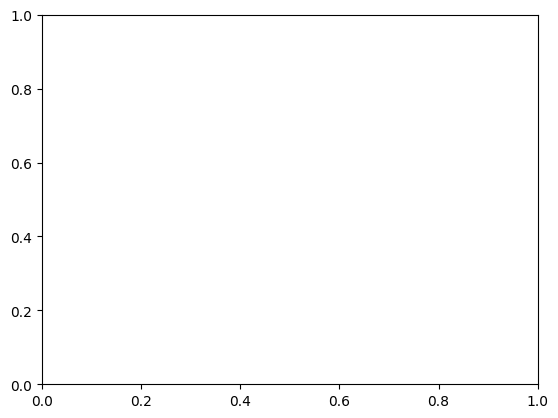

In [ ]:
plt.plot(thrs,portion)
plt.xlabel('thrs')
plt.ylabel('portion')
plt.title('portion of images that have max_obj_area_portion > thrs')
# draw a red dotted line in 0.01 thrs and show its portion value
plt.axvline(x=0.01, color='r', linestyle='dashed')
plt.text(0.01,portion[1],'portion: '+str(portion[1]))
plt.show()

In [3]:
def remove_polygon(image, segmentation, background_color=0, seg_or_bbox: str = 'seg'):
    if image.mode == 'L':
        # Convert background color to single-channel grayscale
        background_color = int(background_color[0])
    
    mask = Image.new('L', image.size, 255)
    draw = ImageDraw.Draw(mask)
    
    if seg_or_bbox == 'seg':
        draw.polygon(segmentation, outline=0, fill=0)
    elif seg_or_bbox == 'bbox':
        x, y, w, h = [int(v) for v in segmentation]
        draw.rectangle((x, y, x+w, y+h), outline=0, fill=0)
        
    mask = Image.fromarray(np.array(mask), mode='L')
    
    if image.mode == 'L':
        background = Image.new('L', image.size, background_color)
    else:
        background = Image.new('RGB', image.size, background_color)
    
    removed_image = Image.composite(image, background, mask)
    return removed_image

In [4]:
def crop_polygon(image, segmentation, seg_or_bbox: str = 'seg'):
    background_removed_image = remove_polygon(image, segmentation,(0, 0, 0), seg_or_bbox)
    original_image_array = np.array(image)
    background_removed_image_array = np.array(background_removed_image)
    
    object_only_image_array = original_image_array - background_removed_image_array
    object_only_image = Image.fromarray(object_only_image_array)
    
    return object_only_image

In [5]:
# return the center area of the image
def center_check(midpoint:list, width:int ,height:int ,thrs: float):
    width_area = [0+width*((1-thrs)/2), width-width*((1-thrs)/2)]
    height_area = [0+height*((1-thrs)/2), height-height*((1-thrs)/2)]
    try:
        if midpoint[0] > width_area[0] and midpoint[0] < width_area[1]:
            if midpoint[1] > height_area[0] and midpoint[1] < height_area[1]:
                return True
            else:
                return False
        else:
            return False
    except:
        return False

In [6]:
def obj_bg_div(json_file_path, og_data_path, save_data_path, seg_or_bbox: str, portion_threshold=0.01, center_threshold=0.7):
    save_data_path = f"{save_data_path}_{portion_threshold}_{seg_or_bbox}_center_{center_threshold}"
    save_data_path_obj = os.path.join(save_data_path, "obj")
    save_data_path_bg = os.path.join(save_data_path, "bg")
    #save_data_path_real_bg = os.path.join(save_data_path, "real_bg")
    
    os.makedirs(save_data_path, exist_ok=True)
    os.makedirs(save_data_path_obj, exist_ok=True)
    os.makedirs(save_data_path_bg, exist_ok=True)
    #os.makedirs(save_data_path_real_bg, exist_ok=True)

    with open(json_file_path) as json_file:
        json_data = json.load(json_file)

    num_obj_images , num_bg_images, num_xbg_images, num_real_bg_images = 0, 0, 0, 0
    for key in tqdm(json_data, desc="Processing images"):
        try:
            max_obj_area_portion = json_data[key]['max_obj_area_portion']
            max_obj_midpoint = json_data[key]['max_obj_midpoint']
            img_width, img_height = int(json_data[key]['width']), int(json_data[key]['height'])

            if max_obj_area_portion:
                img_file = json_data[key]["file_name"]
                image_path = os.path.join(og_data_path, img_file)
                segmentation = json_data[key]['max_obj_segment_points'][0] if seg_or_bbox == 'seg' else json_data[key]['max_obj_bbox']
                json_data[key].pop('max_obj_segment_points', None) if seg_or_bbox == 'bbox' else json_data[key].pop('max_obj_bbox', None)

                with Image.open(image_path) as image:
                    if max_obj_area_portion > portion_threshold: # 물체가 이미지의 일정 비율 이상 차지하는 경우
                        cropped_image = crop_polygon(image, segmentation, seg_or_bbox)
                        cropped_image.save(os.path.join(save_data_path_obj, img_file))
                        json_data[key]["obj_bg"] = "obj"
                        num_obj_images += 1
                    else:
                        if center_check(max_obj_midpoint, img_width, img_height, center_threshold): # 빈 곳의 중심이 이미지의 중심에 가까운 경우
                            removed_image = remove_polygon(image, segmentation,(0, 0, 0), seg_or_bbox)
                            removed_image.save(os.path.join(save_data_path_bg, img_file))
                            json_data[key]["obj_bg"] = "bg"
                            num_bg_images += 1
                        else: # 빈 곳의 중심이 이미지의 중심에 가깝지 않은 경우 (외곽에 위치한 경우)
                            removed_image = remove_polygon(image, segmentation,(0, 0, 0), seg_or_bbox)
                            removed_image.save(os.path.join(save_data_path_bg, img_file))
                            json_data[key]["obj_bg"] = "unusable_bg"
                            num_xbg_images += 1
                        
            else:  # max obj 비어있는 경우 (그냥 real bg로 저장)
                json_data[key]["obj_bg"] = "bg"
                img_file = json_data[key]["file_name"]
                image_path = os.path.join(og_data_path, img_file)

                with Image.open(image_path) as image:
                    image.save(os.path.join(save_data_path_bg, img_file))
                num_real_bg_images += 1
        except Exception as e:
            print(f"Error processing image {json_data[key]['file_name']}: {e}")
    

    print(f"Number of object images {num_obj_images}")
    print(f"Number of usable bg images : {num_bg_images}")
    print(f"Number of unusable bg images : {num_xbg_images}")
    print(f"Number of images in 'real_bg' folder: {num_real_bg_images}")

    print("Saving json file...")
    with open(os.path.join(json_file_path[:-5] + f"_{portion_threshold}_{seg_or_bbox}_center_{center_threshold}.json"), 'w') as outfile:
        json.dump(json_data, outfile)
    print("Done!")

In [7]:
og_data_path = "./data/COCO/Images"
save_data_path = "./data/COCO/Images"
json_file_path = "./data/COCO/Annotations/coco_img_info.json"
seg_or_bbox= "bbox" 
portion_threshold=0.01 
center_threshold=0.7
obj_bg_div(json_file_path, og_data_path, save_data_path, seg_or_bbox, portion_threshold, center_threshold)

Processing images: 100%|██████████| 123287/123287 [11:34<00:00, 177.63it/s]


Number of object images 115053
Number of usable bg images : 5521
Number of unusable bg images : 1644
Number of images in 'real_bg' folder: 1069
Saving json file...
Done!


In [13]:
#making a dictionary that key is obj_bg and value is img_id
def make_obj_bg_dict(json_file_path):
    with open(json_file_path) as json_file:
        json_data = json.load(json_file)
    obj_bg_dict = {}
    for key in json_data:
        if json_data[key]["obj_bg"] not in obj_bg_dict:
            obj_bg_dict[json_data[key]["obj_bg"]] = [key]
        else:
            obj_bg_dict[json_data[key]["obj_bg"]].append(key)
    return obj_bg_dict

In [14]:
obj_bg_dict = make_obj_bg_dict("./data/COCO/Annotations/coco_img_info_0.01_bbox_center_0.7.json")

In [17]:
#dump to json
with open("./data/COCO/Annotations/coco_objbg_info_0.01_bbox_center_0.7.json", 'w') as outfile:
    json.dump(obj_bg_dict, outfile)

In [11]:
os.getcwd()

'/workspace'

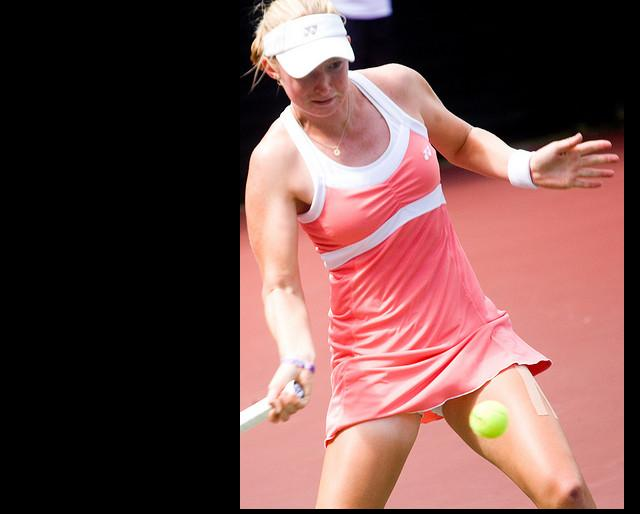

In [12]:
import random
# show sample obj image
obj_img_list = os.listdir("./data/COCO/Images_0.01_bbox_center_0.7/obj")
obj_img = Image.open(os.path.join("./data/COCO/Images_0.01_bbox_center_0.7/obj", random.choice(obj_img_list)))
obj_img